# Dateien verarbeiten

In [1]:
import pandas as pd
import geopandas as gpd
from pathlib import Path

## Import

In [2]:
files = list(Path('../Daten/Shapefiles/').glob("*.gpkg"))

gdf_lakes = []

for file in files:

    gdf = gpd.read_file(file)
    gdf['lake'] = Path(file).stem
    gdf_lakes.append(gdf)

gdf_lakes = pd.concat(gdf_lakes, ignore_index=True)
gdf_lakes = gdf_lakes.to_crs(epsg=2056)
gdf_lakes['length'] = gdf_lakes.geometry.length

C:\Users\simon\AppData\Local\Temp\ipykernel_6664\2048623817.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdf_lakes = pd.concat(gdf_lakes, ignore_index=True)


## Check if wrong categories

In [3]:
categories = ['pa', 'fa', 'ff', 'pp', 'wr', 'ps']
gdf_lakes[gdf_lakes.cat.isin(categories) == False]

,id,cat,comment,gemeinde,geometry,lake,length


## Group

In [4]:
# Remove Water
df = gdf_lakes[gdf_lakes.cat != 'wr']

df = df.pivot_table(index='lake', columns='cat', values='length', aggfunc='sum')
df.fillna(0, inplace=True)
df['sum'] = df.sum(axis=1)

# In Prozent
df = df.div(df['sum'], axis=0) * 100
df = df.round(1)

df.to_csv(Path('../Daten/Excel/analytics.csv'))

df

cat,fa,ff,pa,pp,ps,sum
lake,,,,,,
Lake Baldegg,37.9,54.3,2.4,5.4,0.0,100.0
Lake Bienne,44.8,23.9,2.2,29.1,0.0,100.0
Lake Constance,55.0,9.6,2.2,33.2,0.1,100.0
Lake Geneva,49.1,4.8,0.8,43.0,2.3,100.0
Lake Hallwil,63.9,19.0,0.7,16.4,0.0,100.0
Lake Lucerne,37.8,26.4,1.6,31.9,2.3,100.0
Lake Lugano,31.9,6.5,2.8,48.5,10.4,100.0
Lake Maggiore,40.9,26.7,1.3,28.6,2.4,100.0
Lake Murten,49.6,12.1,4.9,33.5,0.0,100.0


## Generate SVGs

In [5]:
import matplotlib.colors
import matplotlib.pyplot as plt

In [6]:
colors = {
    "??": "#e61dd9",
    "fa": "#28c23f",
    "ff": "#dbffe4",
    "pp": "#ec4243",
    "ps": "#ecffc5",
    "pa": "#e9a23d",
    "wr": "#71e0f8",
}
cmap = matplotlib.colors.ListedColormap([t[1] for t in sorted(colors.items())])

In [7]:
files = list(Path('../Daten/Shapefiles/').glob("*.gpkg"))


for file in files:

    print(file)

    gdf = gpd.read_file(file)
    gdf = gdf.to_crs(epsg=2056)

    # Remove Water
    gdf = gdf[gdf.cat != 'wr']

    fig, ax = plt.subplots(figsize=(30, 30), dpi=100)
    for category, data in gdf.groupby('cat'): # Group by type
        color = colors[category] 
        label = category
        plt.axis('off')
        data.plot(color=color,
                  ax=ax,
                  label=label,
                  linewidth=1
                 )
    ax.legend()
    plt.savefig(Path(f"../Daten/SVG/{Path(file).stem}.svg"), bbox_inches='tight', dpi=100)
    plt.close()


..\Daten\Shapefiles\Lake Baldegg.gpkg
..\Daten\Shapefiles\Lake Bienne.gpkg
..\Daten\Shapefiles\Lake Constance.gpkg
..\Daten\Shapefiles\Lake Geneva.gpkg
..\Daten\Shapefiles\Lake Hallwil.gpkg
..\Daten\Shapefiles\Lake Lucerne.gpkg
..\Daten\Shapefiles\Lake Lugano.gpkg
..\Daten\Shapefiles\Lake Maggiore.gpkg
..\Daten\Shapefiles\Lake Murten.gpkg
..\Daten\Shapefiles\Lake Neuenburg.gpkg
..\Daten\Shapefiles\Lake Sempach.gpkg
..\Daten\Shapefiles\Lake Thun.gpkg
..\Daten\Shapefiles\Lake Zug.gpkg
..\Daten\Shapefiles\Lake Zurich.gpkg


## Drei Kategorien - Check

<Axes: ylabel='Lake Zurich'>

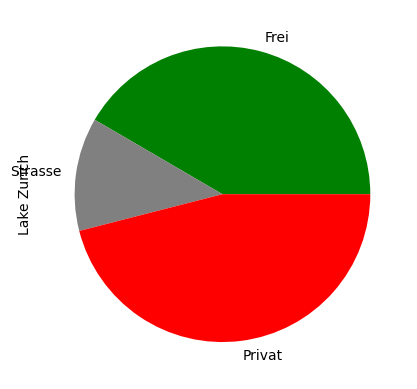

In [44]:
# Remove Water
df = gdf_lakes[gdf_lakes.cat != 'wr']

# Auf 3 Kategorien reduzieren
df.loc[df.cat == 'pa', 'cat'] = 'fa'
df.loc[df.cat == 'ps', 'cat'] = 'ff'

df = df.pivot_table(index='lake', columns='cat', values='length', aggfunc='sum')

df.rename(columns={'fa': 'Frei', 'ff': 'Strasse', 'pp': 'Privat'}, inplace=True)

df.fillna(0, inplace=True)
df['sum'] = df.sum(axis=1)

# In Prozent
df = df.div(df['sum'], axis=0) * 100
df = df.round(1)

df.drop(columns='sum', inplace=True)

i = 13
df.iloc[i].plot.pie(y='cat', colors=['green', 'grey', 'red'])